In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [2]:
sc = SparkContext("local[*]")
spark = SparkSession.builder.appName("models").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [3]:
plt.style.use('seaborn')
msft = yf.Ticker("msft")

C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\323650649.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
df_pd = msft.history(period="max")
df_pd.reset_index(drop=False, inplace=True)
df_pd.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1986-03-13 00:00:00-05:00,0.055241,0.063365,0.055241,0.060657,1031788800,0.0,0.0
1,1986-03-14 00:00:00-05:00,0.060657,0.063907,0.060657,0.062823,308160000,0.0,0.0
2,1986-03-17 00:00:00-05:00,0.062823,0.064448,0.062823,0.063907,133171200,0.0,0.0
3,1986-03-18 00:00:00-05:00,0.063907,0.064448,0.061740,0.062281,67766400,0.0,0.0
4,1986-03-19 00:00:00-05:00,0.062281,0.062823,0.060657,0.061198,47894400,0.0,0.0


In [5]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

In [6]:
df_spark = spark.createDataFrame(df_pd)
va = VectorAssembler(inputCols=["Open", "Volume"], outputCol='features')
v_df = va.transform(df_spark)
selected = v_df.select('features', "Close", "Date")
train_df, test_df = selected.randomSplit([0.7, 0.3], seed=42)

C:\Users\Kacper.pucylo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\Kacper.pucylo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [7]:
lr = LinearRegression(featuresCol='features', labelCol='Close')
lr_model = lr.fit(train_df)
train_df.show(5)

+--------------------+--------------------+-------------------+
|            features|               Close|               Date|
+--------------------+--------------------+-------------------+
|[0.05524120627121...| 0.06065664440393448|1986-03-13 06:00:00|
|[0.05632430253365...| 0.05740739032626152|1986-03-25 06:00:00|
|[0.05794890036217...|0.056324269622564316|1986-03-24 06:00:00|
|[0.05903199813509...| 0.05984431132674217|1986-07-14 06:00:00|
|[0.05903201135620...| 0.06011509895324707|1986-03-27 06:00:00|
+--------------------+--------------------+-------------------+
only showing top 5 rows



In [8]:
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")
training_summary = lr_model.summary
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"r2: {training_summary.r2}")

Coefficients: [0.9999702781570972,-3.8377716683220395e-10]
Intercept: 0.0335152820032768
RMSE: 1.1933828215664468
r2: 0.9997053055653609


In [9]:
train_df.describe().show()

+-------+--------------------+
|summary|               Close|
+-------+--------------------+
|  count|                6575|
|   mean|  42.560488625063414|
| stddev|   69.52273417398537|
|    min|0.056324269622564316|
|    max|   338.5122985839844|
+-------+--------------------+



In [10]:
from pyspark.ml.evaluation import RegressionEvaluator

In [11]:
lr_predictions = lr_model.transform(test_df)
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol="Close", metricName="r2")
print(f"R2 on test data: {evaluator.evaluate(lr_predictions)}")

R2 on test data: 0.9996872638571798


In [12]:
print(f"RMSE on test data: {lr_model.evaluate(test_df).rootMeanSquaredError}")

RMSE on test data: 1.1978033624231852


In [13]:
lr_full_predictions = lr_model.transform(selected)
lr_full_predictions_pd = lr_full_predictions.toPandas()

C:\Users\Kacper.pucylo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


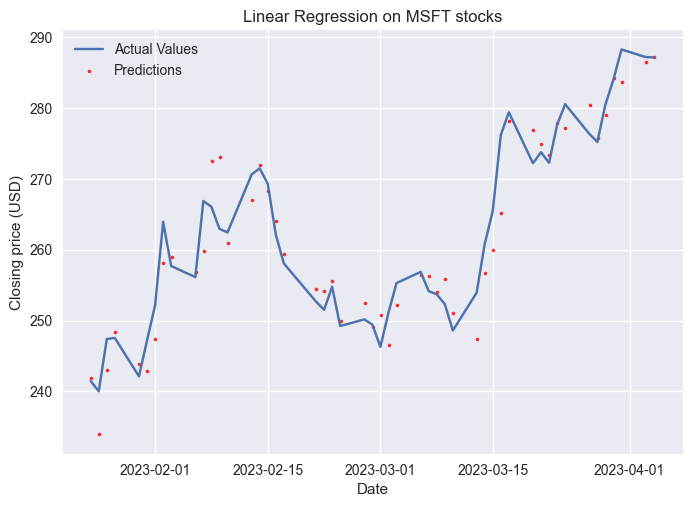

In [14]:
df_pd.sort_index()
plt.plot(df_pd['Date'][-50:], df_pd['Close'][-50:])
plt.xlabel('Date')
plt.ylabel('Closing price (USD)')
plt.title("Linear Regression on MSFT stocks")
plt.scatter(lr_full_predictions_pd['Date'][-50:], lr_full_predictions_pd['prediction'][-50:], c='r', alpha=0.8, s=5)
plt.legend(['Actual Values', 'Predictions'])
plt.show()

In [15]:
r2_values = {"linear": evaluator.evaluate(lr_predictions)}

In [16]:
from pyspark.ml.regression import DecisionTreeRegressor

In [17]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol='Close')
dt_model = dt.fit(train_df)

In [18]:
rmse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
dt_predictions = dt_model.transform(test_df)
r2_values['decision_tree'] = evaluator.evaluate(dt_predictions)
print(f"R2 on test data: {r2_values['decision_tree']}")
print(f"RMSE: {rmse_evaluator.evaluate(dt_predictions)}")

R2 on test data: 0.9905979613445131
RMSE: 6.567612282275033


In [19]:
dt_full_predictions = dt_model.transform(selected)
dt_full_predictions_pd = dt_full_predictions.toPandas()

C:\Users\Kacper.pucylo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


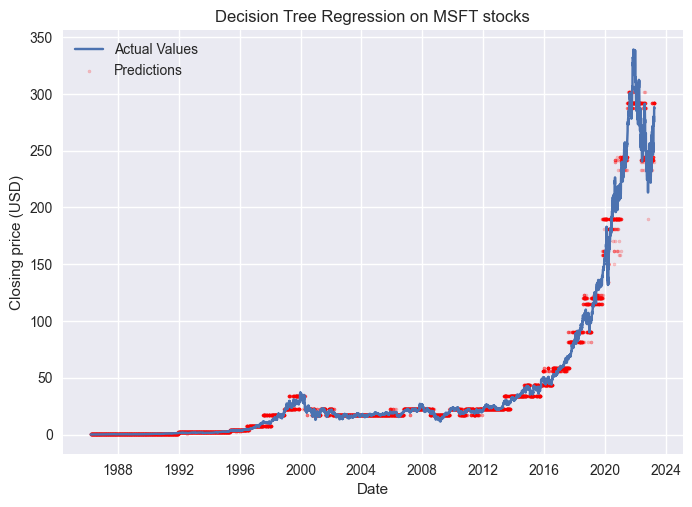

In [20]:
plt.plot(df_pd['Date'], df_pd['Close'])
plt.xlabel('Date')
plt.ylabel('Closing price (USD)')
plt.title('Decision Tree Regression on MSFT stocks')
plt.scatter(dt_full_predictions_pd['Date'], dt_full_predictions_pd['prediction'], c='r', alpha=0.2, s=5)
plt.legend(['Actual Values', 'Predictions'])
plt.show()

In [21]:
from pyspark.ml.regression import RandomForestRegressor

In [22]:
rf = RandomForestRegressor(featuresCol='features', labelCol='Close')
rf_model = rf.fit(train_df)

In [23]:
rf_predictions = rf_model.transform(test_df)
r2_values['random_forest'] = evaluator.evaluate(rf_predictions)
print(f"R2 on test data: {r2_values['random_forest']}")
print(f"RMSE: {rmse_evaluator.evaluate(rf_predictions)}")

R2 on test data: 0.9759970072706117
RMSE: 10.493713115113668


In [24]:
rf_full_predictions = rf_model.transform(selected)
rf_full_predictions_pd = rf_full_predictions.toPandas()

C:\Users\Kacper.pucylo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


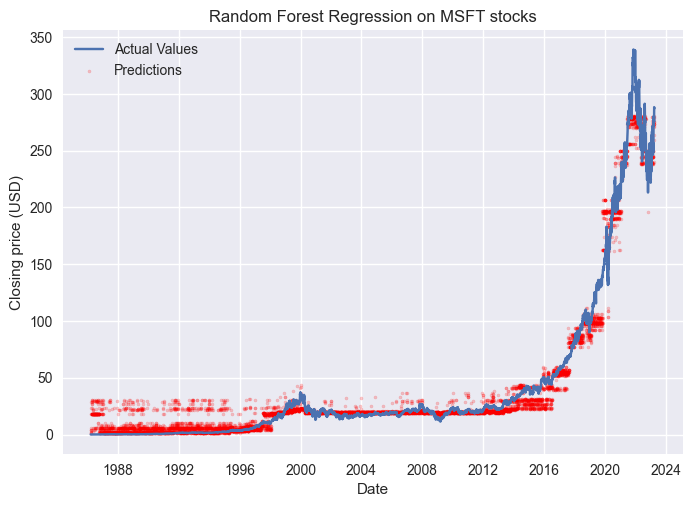

In [25]:
plt.plot(df_pd['Date'], df_pd['Close'])
plt.xlabel('Date')
plt.ylabel('Closing price (USD)')
plt.title('Random Forest Regression on MSFT stocks')
plt.scatter(rf_full_predictions_pd['Date'], rf_full_predictions_pd['prediction'], c='r', alpha=0.2, s=5)
plt.legend(['Actual Values', 'Predictions'])
plt.show()

In [26]:
print(r2_values)

{'linear': 0.9996872638571798, 'decision_tree': 0.9905979613445131, 'random_forest': 0.9759970072706117}


In [27]:
import numpy as np

df_pd['Change'] = np.nan
df_pd.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change
0,1986-03-13 00:00:00-05:00,0.055241,0.063365,0.055241,0.060657,1031788800,0.0,0.0,NaN
1,1986-03-14 00:00:00-05:00,0.060657,0.063907,0.060657,0.062823,308160000,0.0,0.0,NaN
2,1986-03-17 00:00:00-05:00,0.062823,0.064448,0.062823,0.063907,133171200,0.0,0.0,NaN
3,1986-03-18 00:00:00-05:00,0.063907,0.064448,0.061740,0.062281,67766400,0.0,0.0,NaN
4,1986-03-19 00:00:00-05:00,0.062281,0.062823,0.060657,0.061198,47894400,0.0,0.0,NaN


In [28]:
for i in range(len(df_pd) - 1):
    j = i + 1
    if df_pd['Close'][i] < df_pd['Close'][j]:
        df_pd['Change'][j] = 1
    else:
        df_pd['Change'][j] = 0

C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\465671473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd['Change'][j] = 1
C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\465671473.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd['Change'][j] = 0


In [29]:
lr_full_predictions_pd['Change'] = np.nan

In [30]:
for i in range(len(lr_full_predictions_pd) - 1):
    j = i + 1
    if df_pd['Close'][i] < lr_full_predictions_pd['prediction'][j]:
        lr_full_predictions_pd['Change'][j] = 1
    else:
        lr_full_predictions_pd['Change'][j] = 0

C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\1460123127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_full_predictions_pd['Change'][j] = 0
C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\1460123127.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_full_predictions_pd['Change'][j] = 1


In [31]:
lr_full_predictions_pd['Change'][0] = 0
df_pd['Change'][0] = 0

C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\2112039360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_full_predictions_pd['Change'][0] = 0
C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\2112039360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd['Change'][0] = 0


In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

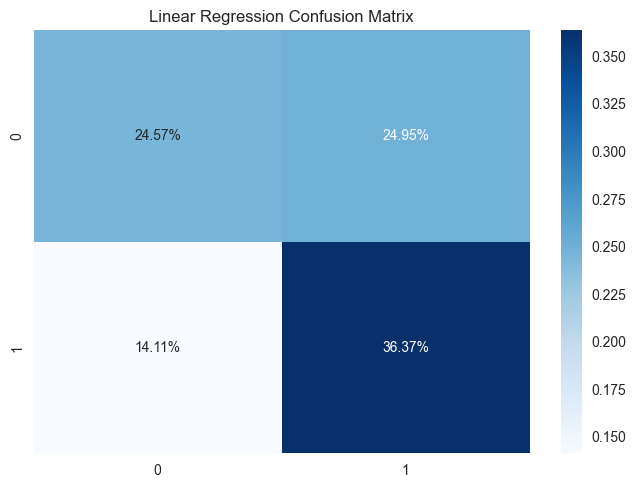

In [33]:
cf_matrix = confusion_matrix(df_pd['Change'], lr_full_predictions_pd['Change'])

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.title("Linear Regression Confusion Matrix")
plt.show()

In [34]:
dt_full_predictions_pd['Change'] = np.nan

for i in range(len(dt_full_predictions_pd) - 1):
    j = i + 1
    if df_pd['Close'][i] < dt_full_predictions_pd['prediction'][j]:
        dt_full_predictions_pd['Change'][j] = 1
    else:
        dt_full_predictions_pd['Change'][j] = 0

C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\1613832255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_full_predictions_pd['Change'][j] = 1
C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\1613832255.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_full_predictions_pd['Change'][j] = 0


C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\1050848427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_full_predictions_pd['Change'][0] = 0


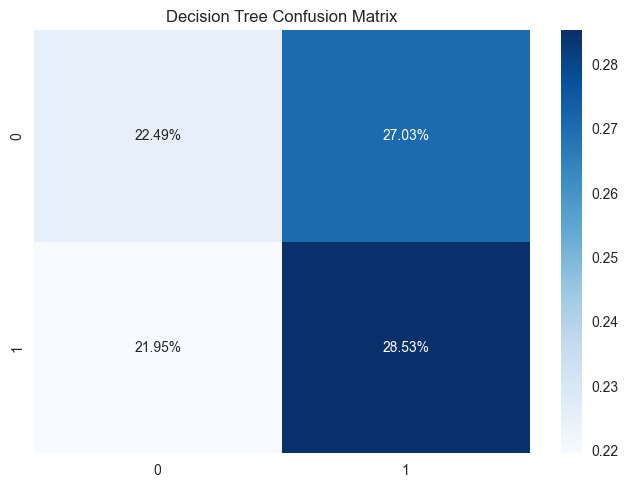

In [35]:
dt_full_predictions_pd['Change'][0] = 0

dt_cf_matrix = confusion_matrix(df_pd['Change'], dt_full_predictions_pd['Change'])

sns.heatmap(dt_cf_matrix/np.sum(dt_cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [36]:
rf_full_predictions_pd['Change'] = np.nan

for i in range(len(rf_full_predictions_pd) - 1):
    j = i + 1
    if df_pd['Close'][i] < rf_full_predictions_pd['prediction'][j]:
        rf_full_predictions_pd['Change'][j] = 1
    else:
        rf_full_predictions_pd['Change'][j] = 0

C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\1086055747.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_full_predictions_pd['Change'][j] = 1
C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\1086055747.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_full_predictions_pd['Change'][j] = 0


C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_19716\963664297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_full_predictions_pd['Change'][0] = 0


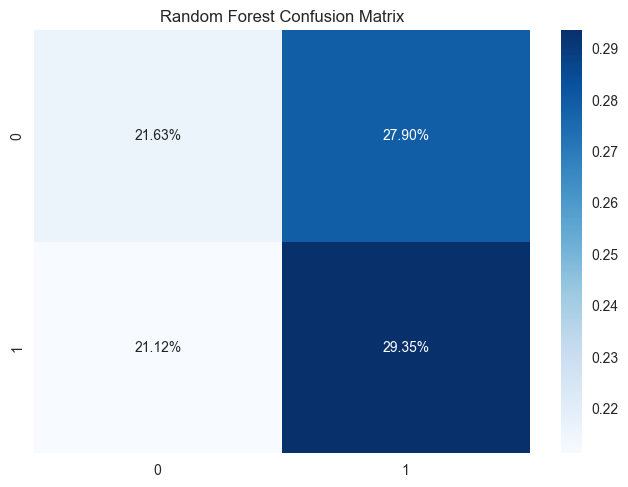

In [37]:
rf_full_predictions_pd['Change'][0] = 0

rf_cf_matrix = confusion_matrix(df_pd['Change'], rf_full_predictions_pd['Change'])

sns.heatmap(rf_cf_matrix/np.sum(rf_cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()